In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import re
import simple_icd_10 as icd

In [3]:
df = pd.read_csv("icd10_categories_descriptions.csv", index_col=0)

In [4]:
icd_codes = [
    f"{row.icd10_category}: {row.description}"
    for _, row in df.iterrows()
]

In [5]:
import openai

In [14]:
YANDEX_CLOUD_FOLDER = ""
YANDEX_CLOUD_API_KEY = ""

client = openai.OpenAI(
    api_key=YANDEX_CLOUD_API_KEY,
    base_url="https://llm.api.cloud.yandex.net/v1"
)

In [15]:
# Метод для получения эмбеддинга запроса
def get_query_embedding(text):
    embedding = get_embedding(text, model=f"emb://{YANDEX_CLOUD_FOLDER}/text-search-query/latest")
    return np.array(embedding)

In [16]:
# Вспомогательный метод для удаления переносов строк
def get_trimmed_text(text):
    return ' '.join(text.split())

In [17]:
def get_embedding(text, model):
    # Убираем лишние переносы
    fixed_text = get_trimmed_text(text)
    return (
        (
            client.embeddings.create(
                input=fixed_text,
                model=model,
                encoding_format="float",
            )
        )
        .data[0]
        .embedding
    )

In [18]:
def get_doc_embeddings(texts):
    doc_embeddings = []
    for text in texts:
        embedding = get_embedding(text, model=f"emb://{YANDEX_CLOUD_FOLDER}/text-search-doc/latest")
        doc_embeddings.append(embedding)
    return doc_embeddings

In [19]:
doc_embedding = get_doc_embeddings(icd_codes)

In [20]:
df["cls"] = doc_embedding

In [21]:
from tqdm import tqdm
from scipy.spatial.distance import cdist
import numpy as np

def find_similar_codes_to_all(icd_codes, doc_embeddings, top_n=1000):
    results = []
    for idx in tqdm(range(len(icd_codes)), desc="Processing ICD codes"):
        query_text = icd_codes[idx]
        query_embedding = np.array(doc_embeddings[idx]).reshape(1, -1)

        other_indices = [i for i in range(len(icd_codes)) if i != idx]
        other_embeddings = [doc_embeddings[i] for i in other_indices]
        other_texts = [icd_codes[i] for i in other_indices]

        distances = cdist(query_embedding, other_embeddings, metric="cosine")
        similarities = 1 - distances

        top_indices = np.argsort(-similarities[0])
        top_matches = [(query_text, other_texts[i], float(similarities[0][i])) for i in top_indices]

        results.append(top_matches)
    return results

In [22]:
def find_similar_codes_to_all(icd_codes, doc_embeddings, top_n=1000):
    results = []
    for idx in tqdm(range(len(icd_codes)), desc="Processing ICD codes"):
        query_text = icd_codes[idx]
        query_embedding = np.array(doc_embeddings[idx]).reshape(1, -1)

        other_indices = [i for i in range(len(icd_codes)) if i != idx]
        other_embeddings = [doc_embeddings[i] for i in other_indices]
        other_texts = [icd_codes[i] for i in other_indices]

        distances = cdist(query_embedding, other_embeddings, metric="cosine")
        similarities = 1 - distances

        top_indices = np.argsort(-similarities[0])
        top_matches = [(query_text, other_texts[i], float(similarities[0][i])) for i in top_indices]

        results.append(top_matches)
    return results

In [23]:
all_similarities = find_similar_codes_to_all(icd_codes, doc_embedding)

Processing ICD codes: 100%|██████████| 1696/1696 [00:27<00:00, 61.54it/s]


In [24]:
flat_similarity_list = []
for similarity_list in all_similarities:
    flat_similarity_list.extend(similarity_list)

In [25]:
codes = set()
for a, b, _ in flat_similarity_list:
    codes.add(a[:3])
    codes.add(b[:3])
codes = sorted(codes)

code_to_idx = {code: idx for idx, code in enumerate(codes)}

matrix = np.full((len(codes), len(codes)), np.nan)

for a, b, sim in flat_similarity_list:
    i = code_to_idx[a[:3]]
    j = code_to_idx[b[:3]]
    matrix[i, j] = sim
    matrix[j, i] = sim
    
np.fill_diagonal(matrix, 1.0)

In [26]:
df_sim_matrix = pd.DataFrame(matrix, index=codes, columns=codes)
print(df_sim_matrix.round(3))

       A01    A02    A03    A04    A05  ...    Z95    Z96    Z97    Z98    Z99
A01  1.000  0.743  0.781  0.768  0.758  ...  0.563  0.587  0.607  0.651  0.564
A02  0.743  1.000  0.781  0.899  0.861  ...  0.511  0.520  0.498  0.499  0.475
A03  0.781  0.781  1.000  0.749  0.735  ...  0.525  0.612  0.613  0.611  0.552
A04  0.768  0.899  0.749  1.000  0.877  ...  0.551  0.577  0.544  0.582  0.504
A05  0.758  0.861  0.735  0.877  1.000  ...  0.499  0.508  0.514  0.535  0.574
..     ...    ...    ...    ...    ...  ...    ...    ...    ...    ...    ...
Z95  0.563  0.511  0.525  0.551  0.499  ...  1.000  0.867  0.679  0.757  0.625
Z96  0.587  0.520  0.612  0.577  0.508  ...  0.867  1.000  0.829  0.829  0.713
Z97  0.607  0.498  0.613  0.544  0.514  ...  0.679  0.829  1.000  0.766  0.846
Z98  0.651  0.499  0.611  0.582  0.535  ...  0.757  0.829  0.766  1.000  0.724
Z99  0.564  0.475  0.552  0.504  0.574  ...  0.625  0.713  0.846  0.724  1.000

[1696 rows x 1696 columns]


In [27]:
df_sim_matrix.to_csv("scores_llm_doc.csv")

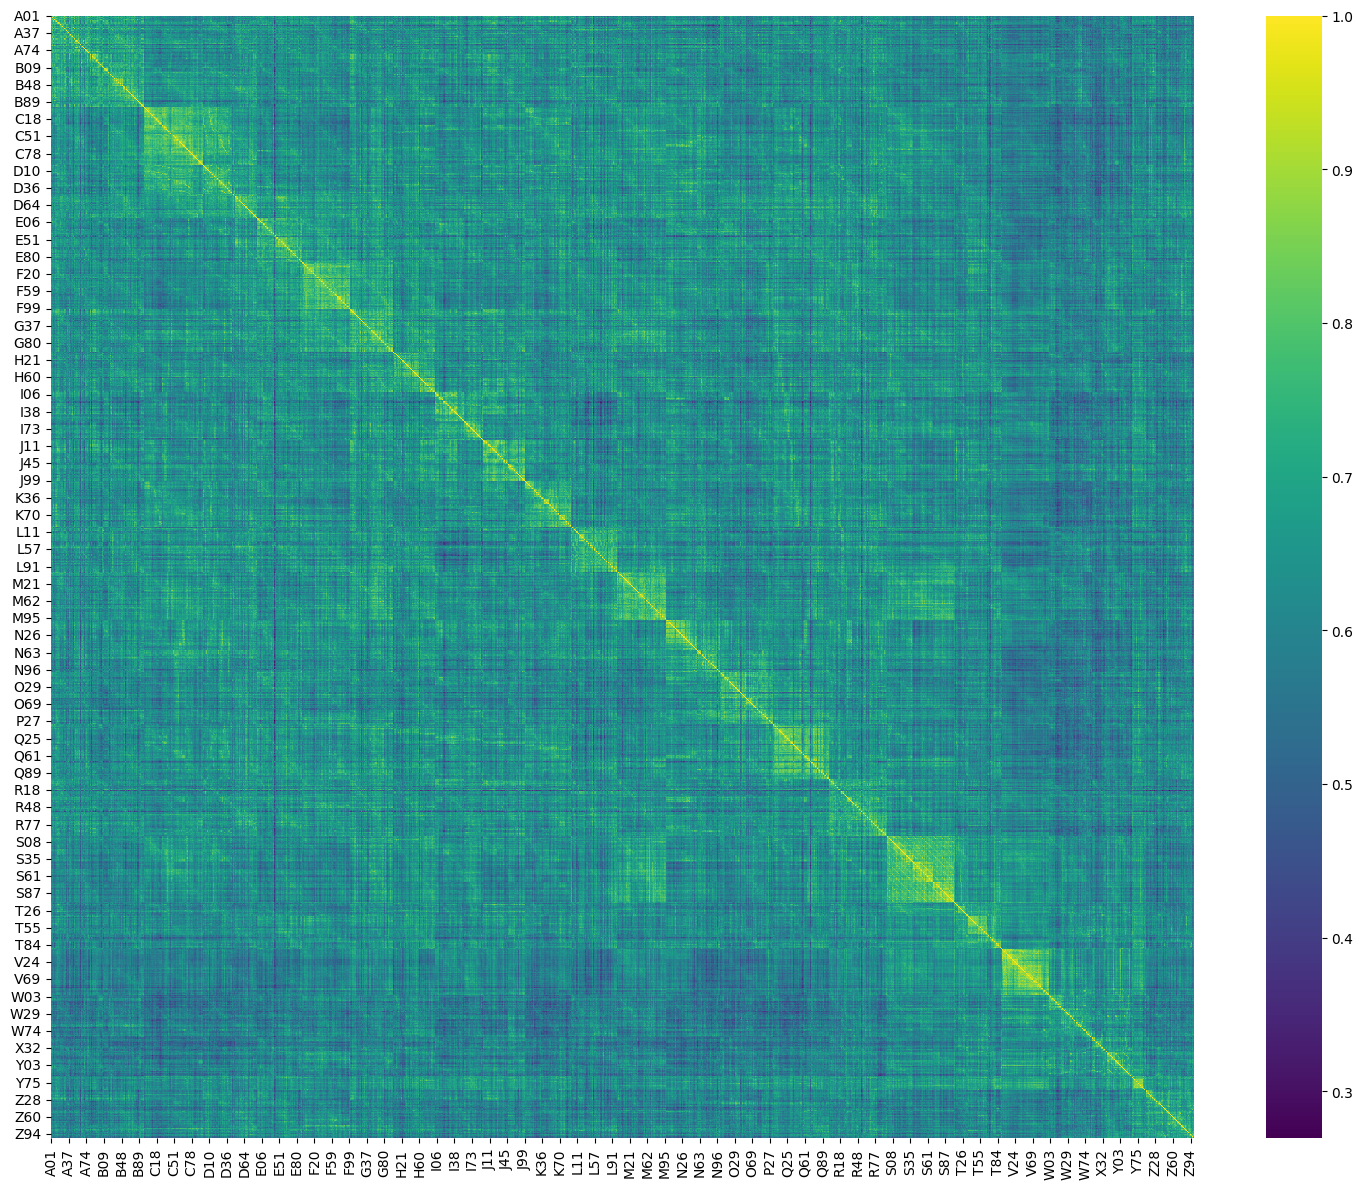

In [16]:
plt.figure(figsize=(15, 12))
sns.heatmap(df_sim_matrix, cmap ='viridis')
plt.tight_layout()
plt.savefig("llm_doc.png", dpi=100, bbox_inches='tight')
plt.show()

In [27]:
df["is_category"] = df["icd10_category"].apply(icd.is_category)
df = df[df["is_category"]]
df["parent"] = df["icd10_category"].apply(icd.get_parent)
df["chapter"] = df["parent"].apply(icd.get_parent)
df["is_chapter"] = df["chapter"].apply(icd.is_chapter)
df.loc[~df['is_chapter'], 'chapter'] = df.loc[~df['is_chapter'], 'chapter'].apply(icd.get_parent)
df["is_chapter"] = df["chapter"].apply(icd.is_chapter)
df.loc[~df['is_chapter'], 'chapter'] = df.loc[~df['is_chapter'], 'chapter'].apply(icd.get_parent)

In [28]:
df["description"] = df["chapter"].apply(icd.get_description)
df = df.sort_values(by='chapter')

/tmp/ipykernel_4710/3321705029.py:42: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout(rect=[0, 0, 0.85, 1])


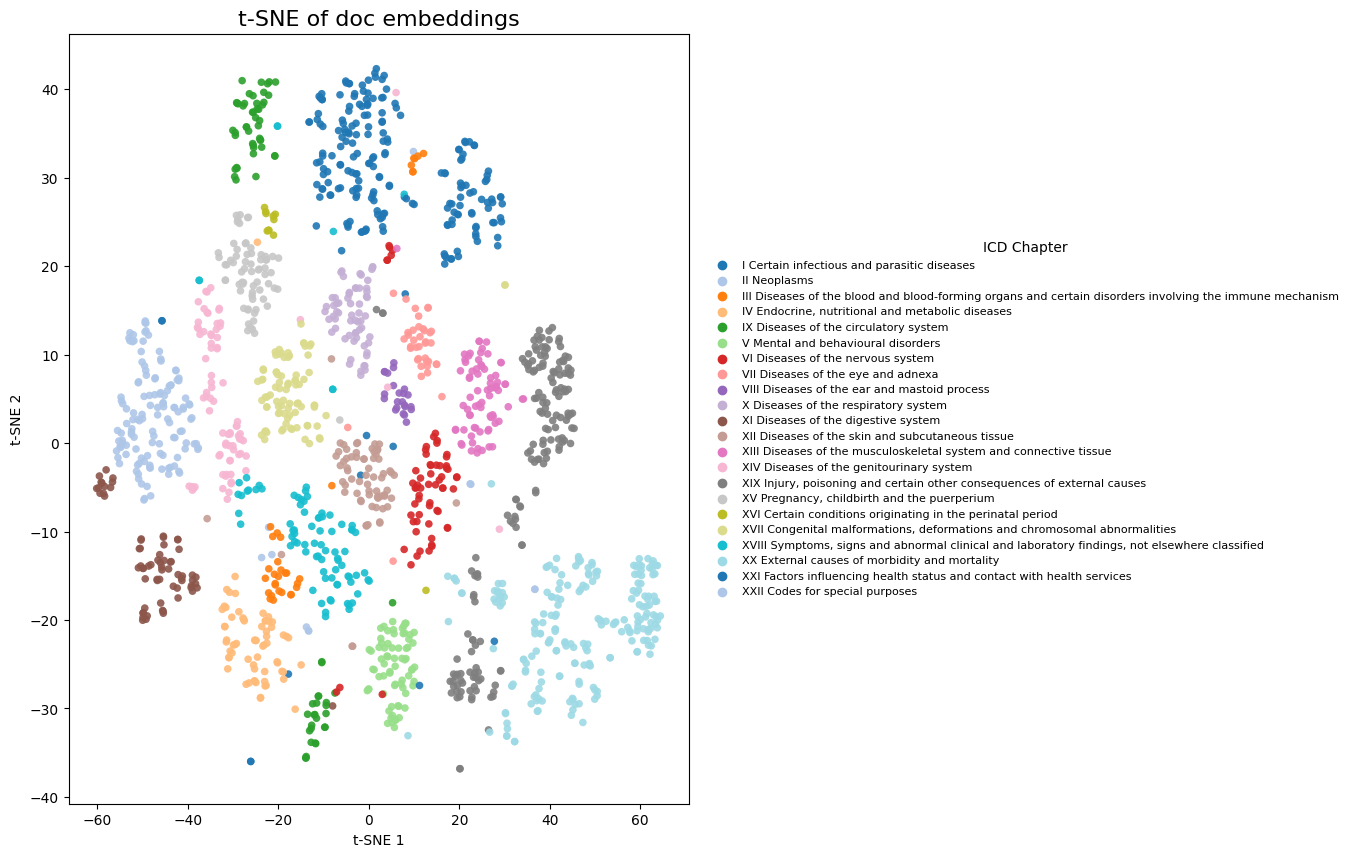

In [32]:
import pandas as pd
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns

embeddings = np.vstack(df['cls'].values)

df['group'] = df['chapter'] + " " + df['description']

tsne = TSNE(n_components=2, random_state=42, perplexity=40)
tsne_results = tsne.fit_transform(embeddings)

df['tsne_1'] = tsne_results[:, 0]
df['tsne_2'] = tsne_results[:, 1]

plt.figure(figsize=(8, 10))
sns.scatterplot(
    x='tsne_1', y='tsne_2',
    hue='group',
    palette='tab20',
    data=df,
    s=30,
    alpha=0.9,
    linewidth=0
)

plt.title("t-SNE of doc embeddings", fontsize=16)
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")

plt.legend(
    title="ICD Chapter",
    bbox_to_anchor=(1.02, 0.5), 
    loc='center left',  
    fontsize=8,
    title_fontsize='medium',
    ncol=1,
    frameon=False
)

plt.tight_layout(rect=[0, 0, 0.85, 1]) 
plt.savefig("llm_doc_tsne.png", dpi=100, bbox_inches='tight')
plt.show()